# Car Price Prediction (Quikr dataset)

This notebook predicts used car prices from basic features (`name`, `company`, `year`, `kms_driven`, `fuel_type`).
We clean the data, build a preprocessing pipeline, train a linear regression model, and evaluate performance with a holdout split and cross-validation.

In [57]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning & preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# Model persistence
import pickle

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Configure visualization settings for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Setup

We use `pandas`, `numpy`, `matplotlib`, `seaborn`, and `scikit-learn` for data work, visualization, and modeling.

## 1. Data Loading & Initial Exploration

Load the raw dataset and examine its structure, size, and data types.

In [2]:
# Load the dataset
car = pd.read_csv("quikr_car.csv")

#### First few records

In [3]:
car.head()

,name,company,year,Price,kms_driven,fuel_type
0,Hyundai Santro Xing XO eRLX Euro III,Hyundai,2007,"80,000","45,000 kms",Petrol
1,Mahindra Jeep CL550 MDI,Mahindra,2006,"4,25,000",40 kms,Diesel
2,Maruti Suzuki Alto 800 Vxi,Maruti,2018,Ask For Price,"22,000 kms",Petrol
3,Hyundai Grand i10 Magna 1.2 Kappa VTVT,Hyundai,2014,"3,25,000","28,000 kms",Petrol
4,Ford EcoSport Titanium 1.5L TDCi,Ford,2014,"5,75,000","36,000 kms",Diesel


#### Dataset dimensions

In [4]:
print(f"Dataset Shape: {car.shape[0]} rows × {car.shape[1]} columns")
car.shape

Dataset Shape: 892 rows × 6 columns


(892, 6)

#### Data types and missing values

In [5]:
car.info()

<class 'pandas.DataFrame'>
RangeIndex: 892 entries, 0 to 891
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   name        892 non-null    str  
 1   company     892 non-null    str  
 2   year        892 non-null    str  
 3   Price       892 non-null    str  
 4   kms_driven  840 non-null    str  
 5   fuel_type   837 non-null    str  
dtypes: str(6)
memory usage: 41.9 KB


## 2. Data Quality Assessment

Examine unique values and identify data quality issues in each feature.

#### Year Column Analysis

In [6]:
# Check year values - expecting only 4-digit years
year_samples = car['year'].unique()[:20]
print(f"Sample year values: {year_samples}")
print(f"Total unique values: {len(car['year'].unique())}")
print("Issue: contains non-numeric entries.")

Sample year values: <StringArray>
['2007', '2006', '2018', '2014', '2015', '2012', '2013', '2016', '2010',
 '2017', '2008', '2011', '2019', '2009', '2005', '2000',  '...', '150k',
 'TOUR', '2003']
Length: 20, dtype: str
Total unique values: 61
Issue: contains non-numeric entries.


#### Price Column Analysis

In [7]:
# Check price values
price_samples = car['Price'].unique()[:15]
print(f"Sample price values: {price_samples}")
print("Issues:")
print("  - Contains 'Ask For Price' entries")
print("  - Prices have commas (string type, not numeric)")

Sample price values: <StringArray>
[       '80,000',      '4,25,000', 'Ask For Price',      '3,25,000',
      '5,75,000',      '1,75,000',      '1,90,000',      '8,30,000',
      '2,50,000',      '1,82,000',      '3,15,000',      '4,15,000',
      '3,20,000',     '10,00,000',      '5,00,000']
Length: 15, dtype: str
Issues:
  - Contains 'Ask For Price' entries
  - Prices have commas (string type, not numeric)


#### KMS Driven Column Analysis

In [8]:
# Check kms_driven values
kms_samples = car['kms_driven'].dropna().unique()[:15]
print(f"Sample kms_driven values: {kms_samples}")
print("Issues:")
print("  - Contains text 'kms' after numbers")
print("  - Has missing (NaN) values")

Sample kms_driven values: <StringArray>
['45,000 kms',     '40 kms', '22,000 kms', '28,000 kms', '36,000 kms',
 '59,000 kms', '41,000 kms', '25,000 kms', '24,530 kms', '60,000 kms',
 '30,000 kms', '32,000 kms', '48,660 kms',  '4,000 kms', '16,934 kms']
Length: 15, dtype: str
Issues:
  - Contains text 'kms' after numbers
  - Has missing (NaN) values


#### Fuel Type Column Analysis

In [9]:
# Check fuel_type values
print(f"Unique fuel types: {car['fuel_type'].unique()}")
print(f"Missing values: {car['fuel_type'].isna().sum()}")
print("Issue: contains missing (NaN) values")

Unique fuel types: <StringArray>
['Petrol', 'Diesel', nan, 'LPG']
Length: 4, dtype: str
Missing values: 55
Issue: contains missing (NaN) values


## 3. Data Cleaning Strategy

### Summary of Issues Found:
| Column | Issue | Action |
|--------|-------|--------|
| year | Contains non-numeric values | Filter numeric only, convert to int |
| Price | Has "Ask For Price" entries & commas | Remove unwanted entries, clean commas, convert to int |
| kms_driven | Has "kms" text suffix & missing values | Extract numeric part only, remove NaN |
| fuel_type | Contains missing values | Remove rows with NaN |
| name | Inconsistent formatting | Keep first 3 words only |

### Data Cleaning Process:
1. Create a backup of original data
2. Clean year column (numeric only)
3. Clean Price column (remove "Ask For Price", remove commas)
4. Clean kms_driven column (extract numbers, remove "kms")
5. Remove rows with missing fuel_type values
6. Standardize car names (first 3 words)
7. Remove outliers (prices > 6 million)
8. Reset index

## 4. Data Cleaning Execution

### Step 1: Create Backup
Preserve original data before cleaning for comparison.

In [10]:
backup = car.copy()
print(f"Backup created: {backup.shape}")

Backup created: (892, 6)


### Step 2: Clean Year Column
Filter to keep only numeric year values (removing entries like 'Used', 'New', etc.)

In [11]:
print(f"Before: {car.shape[0]} rows")
car = car[car['year'].str.isnumeric()]
print(f"After filtering non-numeric years: {car.shape[0]} rows")

Before: 892 rows
After filtering non-numeric years: 842 rows


### Step 3: Convert Year to Integer
Change year from object (string) to integer data type for analysis.

In [12]:
car['year'] = car['year'].astype(int)

### Step 4: Clean Price Column - Remove Invalid Entries
Remove rows where price is listed as "Ask For Price" (missing values).

In [13]:
print(f"Before: {car.shape[0]} rows")
car = car[car['Price'] != "Ask For Price"]
print(f"After removing 'Ask For Price': {car.shape[0]} rows")

Before: 842 rows
After removing 'Ask For Price': 819 rows


### Step 5: Clean Price Column - Remove Commas and Convert to Int
Extract numeric values from prices (remove commas) and convert to integer.

In [14]:
car['Price'] = car['Price'].str.replace(",", '').astype(int)

### Step 6: Clean KMS Driven Column - Extract Numbers
Remove "kms" suffix and extracted numeric values only.

In [15]:
car['kms_driven'] = car['kms_driven'].str.split().str.get(0).str.replace(',', '')

### Step 7: Clean KMS Driven Column - Remove Invalid Values
Filter to keep only rows with numeric kms_driven values (removing NaN and invalid entries).

In [16]:
print(f"Before: {car.shape[0]} rows")
car = car[car['kms_driven'].str.isnumeric()]
print(f"After filtering non-numeric kms_driven: {car.shape[0]} rows")

Before: 819 rows
After filtering non-numeric kms_driven: 817 rows


### Step 8: Convert KMS Driven to Integer
Change kms_driven from string to integer data type.

In [17]:
car['kms_driven'] = car['kms_driven'].astype(int)

#### Check data quality after numerical column cleaning

In [18]:
car.info()

<class 'pandas.DataFrame'>
Index: 817 entries, 0 to 889
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   name        817 non-null    str  
 1   company     817 non-null    str  
 2   year        817 non-null    int64
 3   Price       817 non-null    int64
 4   kms_driven  817 non-null    int64
 5   fuel_type   816 non-null    str  
dtypes: int64(3), str(3)
memory usage: 44.7 KB


### Step 9: Remove Missing Fuel Type Values
Filter out rows where fuel_type is NaN/missing.

In [19]:
print(f"Before: {car.shape[0]} rows")
car = car[~car['fuel_type'].isna()]
print(f"After removing NaN fuel_type: {car.shape[0]} rows")

Before: 817 rows
After removing NaN fuel_type: 816 rows


### Step 10: Standardize Car Names
Keep only the first 3 words of car names to standardize naming convention.

In [20]:
car['name'] = car['name'].str.split(' ').str.slice(0, 3).str.join(' ')

### Step 11: Reset Index
Reset DataFrame index after all filtering operations.

In [21]:
car = car.reset_index(drop=True)

#### View cleaned dataset

In [22]:
car

,name,company,year,Price,kms_driven,fuel_type
0,Hyundai Santro Xing,Hyundai,2007,80000,45000,Petrol
1,Mahindra Jeep CL550,Mahindra,2006,425000,40,Diesel
2,Hyundai Grand i10,Hyundai,2014,325000,28000,Petrol
3,Ford EcoSport Titanium,Ford,2014,575000,36000,Diesel
4,Ford Figo,Ford,2012,175000,41000,Diesel
...,...,...,...,...,...,...
811,Maruti Suzuki Ritz,Maruti,2011,270000,50000,Petrol
812,Tata Indica V2,Tata,2009,110000,30000,Diesel
813,Toyota Corolla Altis,Toyota,2009,300000,132000,Petrol
814,Tata Zest XM,Tata,2018,260000,27000,Diesel


#### Final data quality check

In [23]:
car.info()

<class 'pandas.DataFrame'>
RangeIndex: 816 entries, 0 to 815
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        816 non-null    object
 1   company     816 non-null    str   
 2   year        816 non-null    int64 
 3   Price       816 non-null    int64 
 4   kms_driven  816 non-null    int64 
 5   fuel_type   816 non-null    str   
dtypes: int64(3), object(1), str(2)
memory usage: 38.4+ KB


#### Statistical summary of cleaned data

In [24]:
car.describe()

,year,Price,kms_driven
count,816.000000,8.160000e+02,816.000000
mean,2012.444853,4.117176e+05,46275.531863
std,4.002992,4.751844e+05,34297.428044
min,1995.000000,3.000000e+04,0.000000
25%,2010.000000,1.750000e+05,27000.000000
50%,2013.000000,2.999990e+05,41000.000000
75%,2015.000000,4.912500e+05,56818.500000
max,2019.000000,8.500003e+06,400000.000000


### Step 12: Remove Price Outliers
Filter out extreme outliers (prices > 6 million) to improve model robustness.

In [ ]:
print(f"Before: {car.shape[0]} rows, Price range: Rs.{car['Price'].min():,} - Rs.{car['Price'].max():,}")
car = car[car['Price'] < 6e6].reset_index(drop=True)
print(f"After removing outliers: {car.shape[0]} rows, Price range: Rs.{car['Price'].min():,} - Rs.{car['Price'].max():,}")

Before: 816 rows, Price range: ₹30,000 - ₹8,500,003
After removing outliers: 815 rows, Price range: ₹30,000 - ₹3,100,000


#### Final cleaned dataset

In [25]:
car.head(10)

,name,company,year,Price,kms_driven,fuel_type
0,Hyundai Santro Xing,Hyundai,2007,80000,45000,Petrol
1,Mahindra Jeep CL550,Mahindra,2006,425000,40,Diesel
2,Hyundai Grand i10,Hyundai,2014,325000,28000,Petrol
3,Ford EcoSport Titanium,Ford,2014,575000,36000,Diesel
4,Ford Figo,Ford,2012,175000,41000,Diesel
5,Hyundai Eon,Hyundai,2013,190000,25000,Petrol
6,Ford EcoSport Ambiente,Ford,2016,830000,24530,Diesel
7,Maruti Suzuki Alto,Maruti,2015,250000,60000,Petrol
8,Skoda Fabia Classic,Skoda,2010,182000,60000,Petrol
9,Maruti Suzuki Stingray,Maruti,2015,315000,30000,Petrol


#### Export cleaned data for future use

In [26]:
car.to_csv("Cleaned_Car_data.csv", index=False)

## 5. Exploratory Data Analysis (EDA)

Visualize relationships between features and price to understand broad patterns.

### Company vs Price

Boxplots show brand-level price differences.

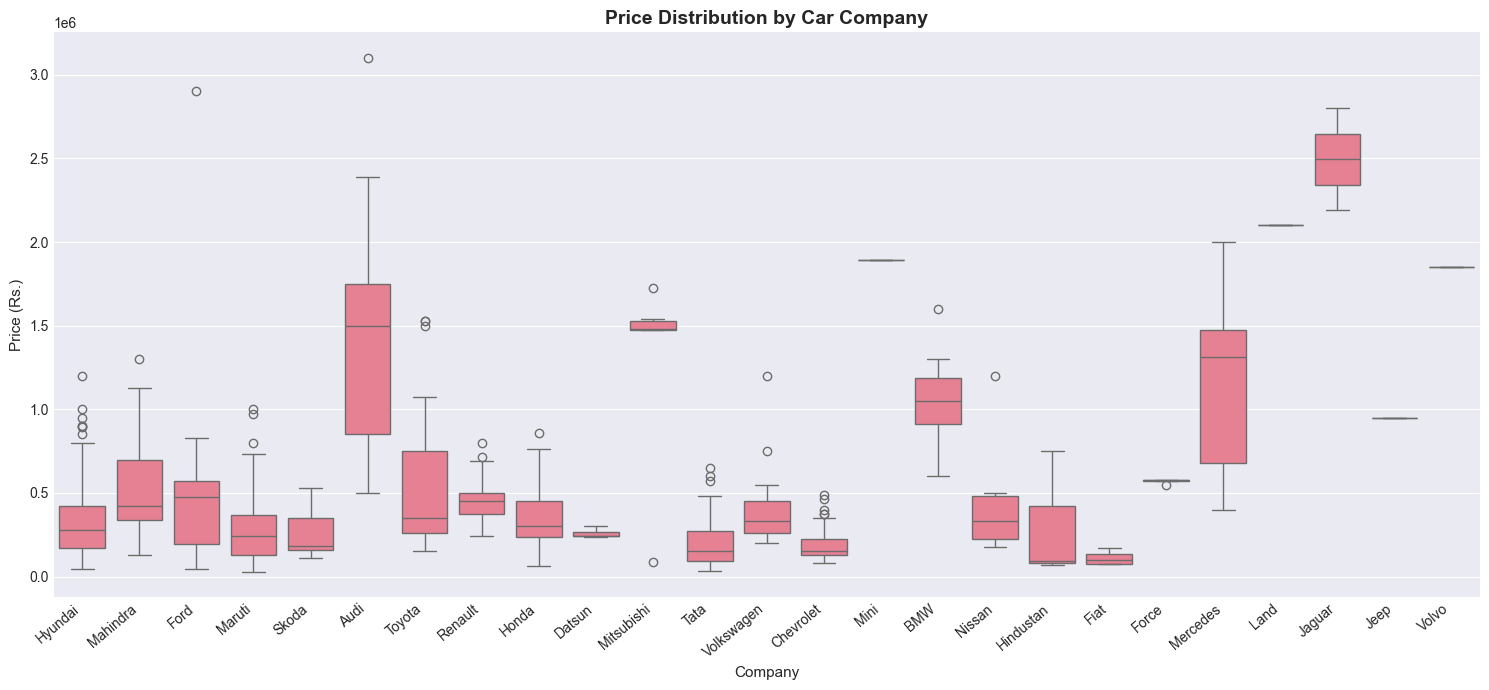

In [58]:
plt.figure(figsize=(15,7))
ax=sns.boxplot(x='company',y='Price',data=car)
plt.xticks(rotation=40, ha='right')
plt.title('Price Distribution by Car Company', fontsize=14, fontweight='bold')
plt.ylabel('Price (Rs.)', fontsize=11)
plt.xlabel('Company', fontsize=11)
plt.tight_layout()
plt.show()

### Year vs Price

Newer models trend higher; spread visible across years.

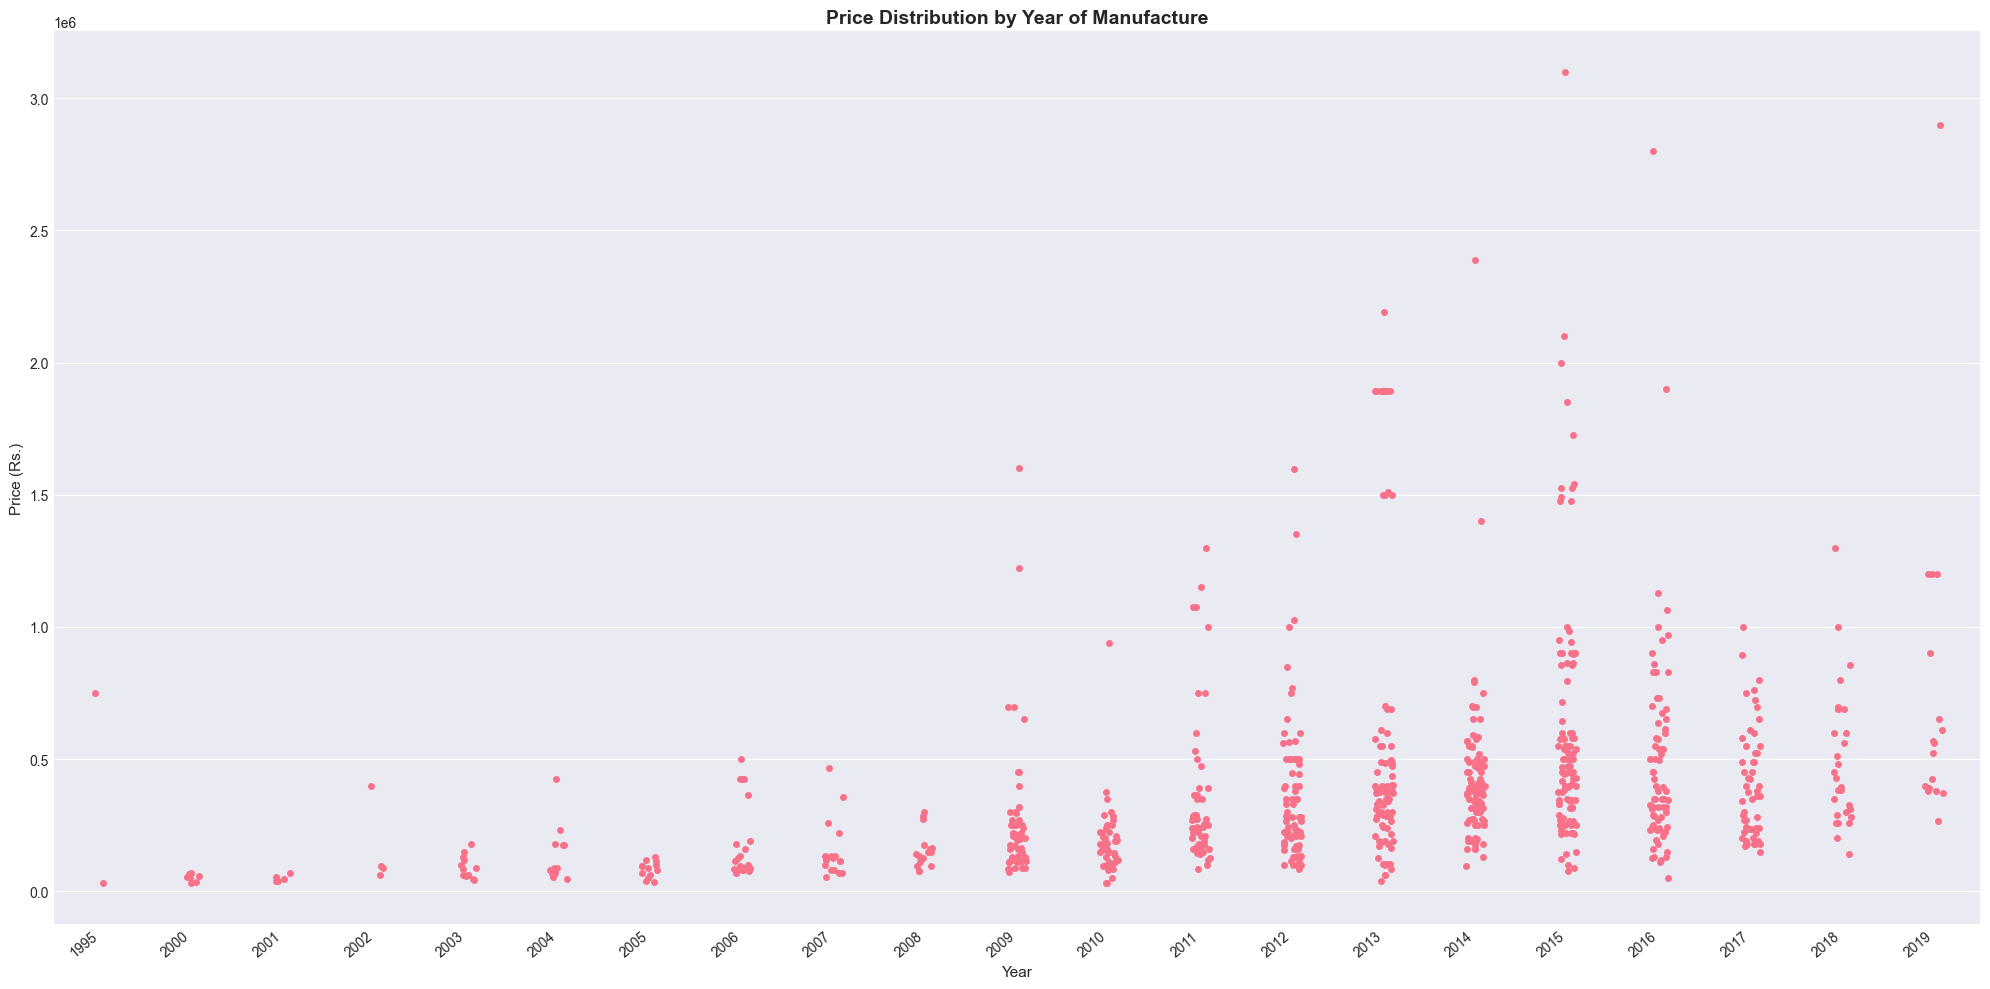

In [59]:
plt.figure(figsize=(20,10))
ax=sns.stripplot(x='year',y='Price',data=car)
plt.xticks(rotation=40, ha='right')
plt.title('Price Distribution by Year of Manufacture', fontsize=14, fontweight='bold')
plt.ylabel('Price (Rs.)', fontsize=11)
plt.xlabel('Year', fontsize=11)
plt.tight_layout()
plt.show()

### KMS Driven vs Price

Higher mileage typically lowers price; check nonlinearity.

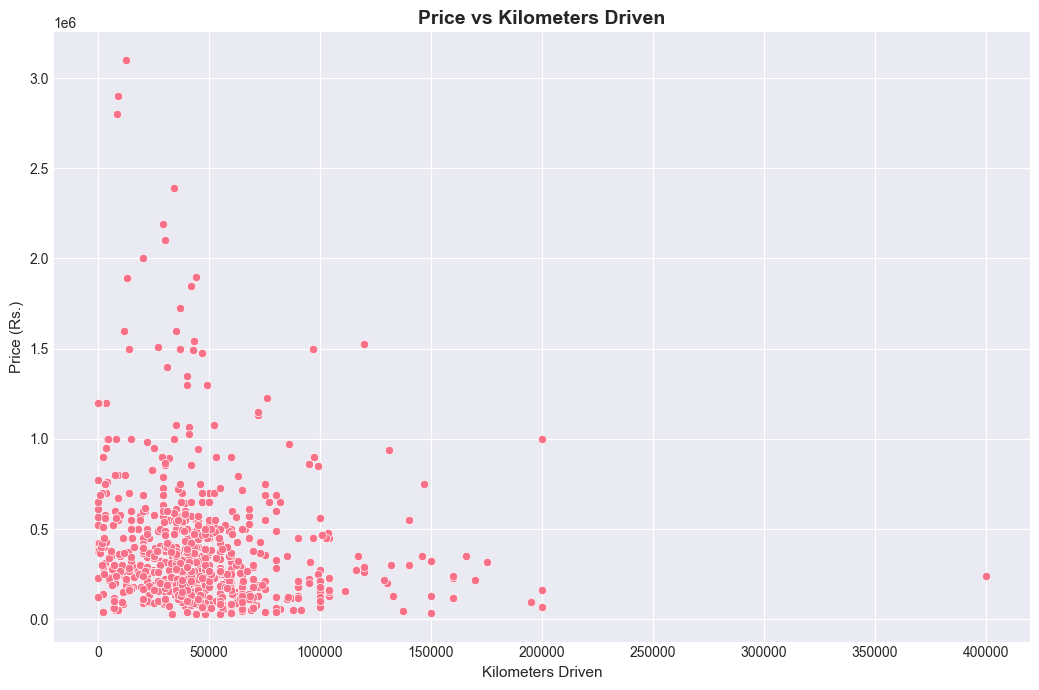

In [60]:
sns.relplot(x='kms_driven',y='Price',data=car,height=7,aspect=1.5)
plt.title('Price vs Kilometers Driven', fontsize=14, fontweight='bold')
plt.xlabel('Kilometers Driven', fontsize=11)
plt.ylabel('Price (Rs.)', fontsize=11)
plt.tight_layout()
plt.show()

### Fuel Type vs Price

Compare pricing across petrol, diesel, and CNG.

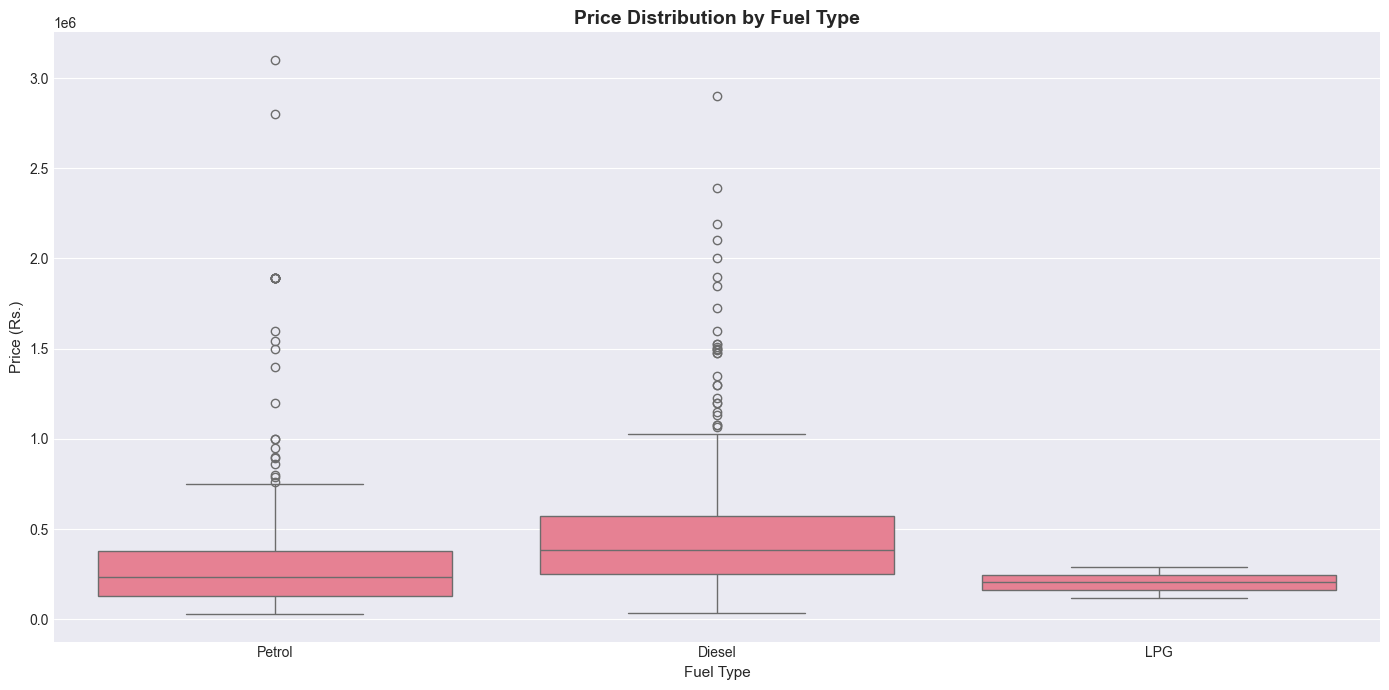

In [61]:
plt.figure(figsize=(14,7))
sns.boxplot(x='fuel_type',y='Price',data=car)
plt.title('Price Distribution by Fuel Type', fontsize=14, fontweight='bold')
plt.ylabel('Price (Rs.)', fontsize=11)
plt.xlabel('Fuel Type', fontsize=11)
plt.tight_layout()
plt.show()

### Company × Fuel × Year

Multi-factor view of how brand, fuel, and year affect price.

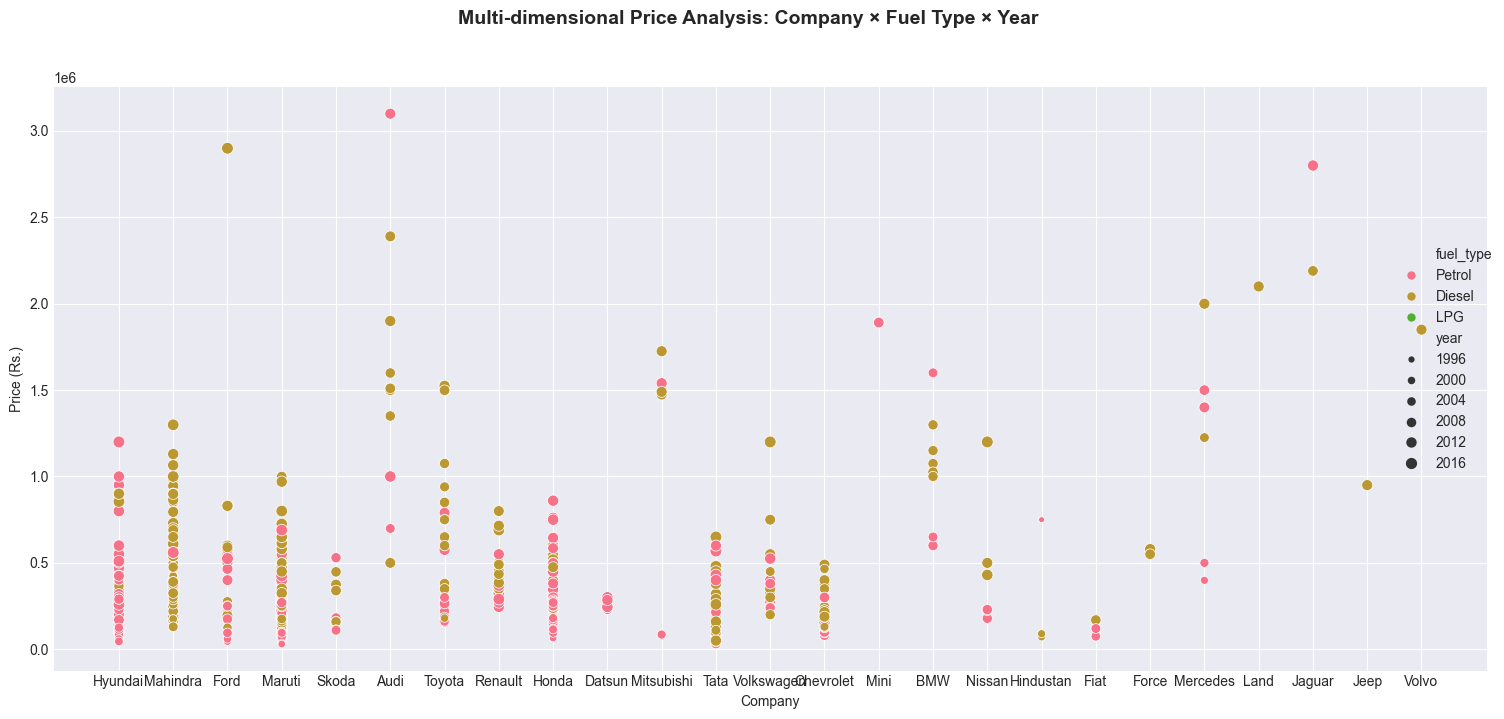

In [62]:
ax=sns.relplot(x='company',y='Price',data=car,hue='fuel_type',size='year',height=7,aspect=2)
ax.fig.suptitle('Multi-dimensional Price Analysis: Company × Fuel Type × Year', fontsize=14, fontweight='bold', y=1.02)
ax.set(xlabel='Company', ylabel='Price (Rs.)')
plt.tight_layout()
plt.show()

## 6. Data Preprocessing & Feature Engineering

Prepare data for machine learning model by separating features and target variable.

In [32]:
# Separate features (X) and target variable (y)
X = car.drop(columns='Price')  # All features except Price
y = car['Price']               # Target: Car Price

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Features: {list(X.columns)}")

Features shape: (815, 5)
Target shape: (815,)
Features: ['name', 'company', 'year', 'kms_driven', 'fuel_type']


### Train-Test Split

Divide data into training (80%) and testing (20%) sets. The model learns from training data and is evaluated on unseen test data.

In [33]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✓ Data split completed")
print(f"  Training set: {X_train.shape}")
print(f"  Testing set: {X_test.shape}")

✓ Data split completed
  Training set: (652, 5)
  Testing set: (163, 5)


## 7. Model Building

Import necessary ML libraries and build a pipeline that:
1. Encodes categorical features (name, company, fuel_type) using OneHotEncoder
2. Passes numerical features (year, kms_driven) through unchanged
3. Trains a Linear Regression model on transformed features

In [34]:
# Import model and preprocessing libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

### Step 1: Fit OneHotEncoder on Categorical Features

Initialize and fit the encoder with all possible categories from the training data. This ensures the encoder knows all categories it might encounter during prediction.

In [35]:
# Fit OneHotEncoder on all categorical features  
# This learns all unique categories in each feature
ohe = OneHotEncoder()
ohe.fit(X[['name', 'company', 'fuel_type']])

,"categories categories: 'auto' or a list of array-like, default='auto'Categories (unique values) per feature:- 'auto' : Determine categories automatically from the training data.- list : ``categories[i]`` holds the categories expected in the ith column. The passed categories should not mix strings and numeric values within a single feature, and should be sorted in case of numeric values.The used categories can be found in the ``categories_`` attribute... versionadded:: 0.20",'auto'
,"drop drop: {'first', 'if_binary'} or an array-like of shape (n_features,), default=NoneSpecifies a methodology to use to drop one of the categories perfeature. This is useful in situations where perfectly collinearfeatures cause problems, such as when feeding the resulting datainto an unregularized linear regression model.However, dropping one category breaks the symmetry of the originalrepresentation and can therefore induce a bias in downstream models,for instance for penalized linear classification or regression models.- None : retain all features (the default).- 'first' : drop the first category in each feature. If only one category is present, the feature will be dropped entirely.- 'if_binary' : drop the first category in each feature with two categories. Features with 1 or more than 2 categories are left intact.- array : ``drop[i]`` is the category in feature ``X[:, i]`` that should be dropped.When `max_categories` or `min_frequency` is configured to groupinfrequent categories, the dropping behavior is handled after thegrouping... versionadded:: 0.21 The parameter `drop` was added in 0.21... versionchanged:: 0.23 The option `drop='if_binary'` was added in 0.23... versionchanged:: 1.1 Support for dropping infrequent categories.",None
,"sparse_output sparse_output: bool, default=TrueWhen ``True``, it returns a :class:`scipy.sparse.csr_matrix`,i.e. a sparse matrix in ""Compressed Sparse Row"" (CSR) format... versionadded:: 1.2 `sparse` was renamed to `sparse_output`",True
,"dtype dtype: number type, default=np.float64Desired dtype of output.",<class 'numpy.float64'>
,"handle_unknown handle_unknown: {'error', 'ignore', 'infrequent_if_exist', 'warn'}, default='error'Specifies the way unknown categories are handled during :meth:`transform`.- 'error' : Raise an error if an unknown category is present during transform.- 'ignore' : When an unknown category is encountered during transform, the resulting one-hot encoded columns for this feature will be all zeros. In the inverse transform, an unknown category will be denoted as None.- 'infrequent_if_exist' : When an unknown category is encountered during transform, the resulting one-hot encoded columns for this feature will map to the infrequent category if it exists. The infrequent category will be mapped to the last position in the encoding. During inverse transform, an unknown category will be mapped to the category denoted `'infrequent'` if it exists. If the `'infrequent'` category does not exist, then :meth:`transform` and :meth:`inverse_transform` will handle an unknown category as with `handle_unknown='ignore'`. Infrequent categories exist based on `min_frequency` and `max_categories`. Read more in the :ref:`User Guide `.- 'warn' : When an unknown category is encountered during transform a warning is issued, and the encoding then proceeds as described for `handle_unknown=""infrequent_if_exist""`... versionchanged:: 1.1 `'infrequent_if_exist'` was added to automatically handle unknown categories and infrequent categories... versionadded:: 1.6 The option `""warn""` was added in 1.6.",'error'
,"min_frequency min_frequency: int or float, default=NoneSpecifies the minimum frequency below which a category will beconsidered infrequent.- If `int`, categories with a smaller cardinality will be considered infrequent.- If `float`, categories with a smaller cardinality than `min_frequency * n_samples` will be considered infrequent... versionadded:: 1.1 Read more in the :ref:`User Guide `.",None
,"max_catego

### Step 2: Create Column Transformer

Build a preprocessing pipeline that:
- **OneHotEncodes** categorical features (name, company, fuel_type)
- **Passes through** numerical features (year, kms_driven) unchanged

In [36]:
# Create column transformer to apply different preprocessing to different column types
column_trans = make_column_transformer(
    (OneHotEncoder(categories=ohe.categories_), ['name', 'company', 'fuel_type']),
    remainder='passthrough'  # Pass through other columns (year, kms_driven) as-is
)

### Step 3: Initialize Linear Regression Model

Create a Linear Regression model instance that will learn the relationship between features and price.

In [37]:
# Initialize Linear Regression model
lr = LinearRegression()

### Step 4: Create Pipeline

Combine preprocessing (column_trans) and model (lr) into a single pipeline for seamless data transformation and prediction.

In [38]:
# Create pipeline: standardize data → train model
pipe = make_pipeline(column_trans, lr)

### Step 5: Train the Model

Fit the pipeline on training data. The model learns weight for each feature to minimize prediction error.

In [39]:
# Train the model on training data
pipe.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('linearregression', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('onehotencoder', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the differ

### Step 6: Make Predictions on Test Set

Use the trained model to predict prices for unseen test data.

In [40]:
# Make predictions on test set
y_pred = pipe.predict(X_test)

### Step 7: Evaluate Model - Initial R² Score

Calculate R² score on test set. R² ranges from 0 to 1, where 1 = perfect predictions and 0 = model predicts mean value.

In [41]:
# Calculate R² score (coefficient of determination)
r2_initial = r2_score(y_test, y_pred)
print(f"Initial R² (test): {r2_initial:.4f}")

Initial R² (test): 0.5732


### Display Best R² Score from Optimization Search

### Final Model Training with Optimized Configuration

Retrain the complete model using the best random state found during optimization. This ensures we deploy the most stable and best-performing model.

## Model Persistence

Save the fitted pipeline for reuse in the web app.

In [44]:
pickle.dump(pipe, open('LinearRegressionModel.pkl', 'wb'))

In [45]:
pipe.predict(pd.DataFrame([['Maruti Suzuki Swift', 'Maruti', 2019, 100, 'Petrol']], columns=['name', 'company', 'year', 'kms_driven', 'fuel_type']))

array([418329.03647101])

### Example: Real-World Price Prediction

Demonstrate the model's predictive power by estimating the price of a specific car. This shows how the model would be used in production for predicting unknown car prices.

**Example Car:**
- **Model:** Maruti Suzuki Swift (first 3 words)
- **Company:** Maruti
- **Year:** 2019
- **Kilometers Driven:** 100 km
- **Fuel Type:** Petrol

## Summary

- Cleaned and standardized the data
- Trained a linear regression pipeline
- Evaluated with a holdout split and cross-validation
- Saved the model for the Flask app

In [46]:
# Cross-validation on our regression pipeline (R²)
from sklearn.model_selection import KFold, cross_val_score

# Use features/target from our dataset and pipeline defined above
cv = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(estimator=pipe, X=X, y=y, cv=cv, scoring='r2')

print(f"CV R² per fold: {scores}")
print(f"CV R² mean: {scores.mean():.4f} (+/- {scores.std():.4f})")

CV R² per fold: [ 0.49526498  0.7269769   0.70909001  0.6783841  -0.07462402  0.69458959
  0.60658266  0.7654326   0.80222012  0.65640171]
CV R² mean: 0.6060 (+/- 0.2409)


In [51]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.datasets import make_regression

# 1. Use this notebook's dataset
X = car.drop(columns='Price')
y = car['Price']

# 2. Use the preprocessing+model pipeline built above
model = pipe

# 3. Configure the RepeatedKFold cross-validator
rkf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# 4. Perform cross-validation using R²
scores = cross_val_score(model, X, y, scoring='r2', cv=rkf, n_jobs=-1)

# 5. Analyze results
print(f"R² per fold: {scores}")
print(f"Mean R²: {np.mean(scores):.4f} (Std: {np.std(scores):.4f})")

R² per fold: [0.57062262 0.43613993 0.71824045 0.7028499  0.79131745 0.65927128
 0.74331919 0.68684389 0.65070424 0.42131754 0.71730417 0.80993713
 0.55687196 0.74920726 0.55314575 0.43583249 0.4844771  0.73580273
 0.6928892  0.42287835 0.39858842 0.5317639  0.75914475 0.59460953
 0.50247269 0.70528322 0.77385395 0.65437724 0.77668426 0.79965195]
Mean R²: 0.6345 (Std: 0.1288)


## 10. Additional Metrics

Beyond R², these regression metrics help judge error magnitude and consistency:
- MAE: average absolute error (in currency units)
- RMSE: root mean squared error, penalizes large errors
- MAPE: average absolute percentage error (scaled for interpretable %)

We report them for the test split and via RepeatedKFold cross-validation for robustness.

In [54]:
# Test-set metrics: R², MAE, RMSE, MAPE
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Uses previously computed y_test and y_pred
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
# RMSE via sqrt of MSE (compatible across sklearn versions)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
# MAPE computed manually (avoid sklearn version differences)
mape = np.mean(np.abs((y_test - y_pred) / np.maximum(np.abs(y_test), 1e-8)))

print(f"Test R²:   {r2:.4f}")
print(f"Test MAE:  {mae:,.0f}")
print(f"Test RMSE: {rmse:,.0f}")
print(f"Test MAPE: {mape*100:.2f}%")

Test R²:   0.5732
Test MAE:  148,129
Test RMSE: 294,822
Test MAPE: 43.24%


In [55]:
# RepeatedKFold cross-validation metrics: R², MAE, RMSE, MAPE
import numpy as np
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.metrics import make_scorer

# Use existing features/target and pipeline
rkf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# R²
r2_scores = cross_val_score(pipe, X, y, scoring='r2', cv=rkf, n_jobs=-1)

# MAE (scikit-learn uses negative for loss-based scorers)
mae_scores = -cross_val_score(pipe, X, y, scoring='neg_mean_absolute_error', cv=rkf, n_jobs=-1)

# RMSE via sqrt of MSE
mse_scores = -cross_val_score(pipe, X, y, scoring='neg_mean_squared_error', cv=rkf, n_jobs=-1)
rmse_scores = np.sqrt(mse_scores)

# MAPE via custom scorer (lower is better)
def mape_fn(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8)))

mape_scorer = make_scorer(mape_fn, greater_is_better=False)
mape_scores = -cross_val_score(pipe, X, y, scoring=mape_scorer, cv=rkf, n_jobs=-1)

print("RepeatedKFold metrics (mean ± std):")
print(f"  R²:   {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
print(f"  MAE:  {np.mean(mae_scores):,.0f} ± {np.std(mae_scores):,.0f}")
print(f"  RMSE: {np.mean(rmse_scores):,.0f} ± {np.std(rmse_scores):,.0f}")
print(f"  MAPE: {np.mean(mape_scores)*100:.2f}% ± {np.std(mape_scores)*100:.2f}%")

RepeatedKFold metrics (mean ± std):
  R²:   0.6345 ± 0.1288
  MAE:  132,089 ± 20,525
  RMSE: 219,455 ± 56,518
  MAPE: 51.64% ± 10.18%


In [56]:
# Export trained Linear Regression pipeline to JSON (safer than pickle)
import json
import pickle
import numpy as np

# Load existing pipeline once to convert (local/trusted file)
pipe = pickle.load(open('LinearRegressionModel.pkl', 'rb'))
ct = pipe.named_steps['columntransformer']
lr = pipe.named_steps['linearregression']

feature_names = ct.get_feature_names_out()
coefs = lr.coef_
intercept = float(lr.intercept_)

model_json = {
    'intercept': intercept,
    'numeric': {},
    'categorical': {
        'name': {},
        'company': {},
        'fuel_type': {}
    }
}

for fname, coef in zip(feature_names, coefs):
    # Normalize name from ColumnTransformer (e.g., 'onehotencoder__name_Toyota' or 'year')
    simple = fname.split('__')[-1]
    # Categorical mappings
    for col in ['name', 'company', 'fuel_type']:
        prefix = col + '_'
        if simple.startswith(prefix):
            category = simple[len(prefix):]
            model_json['categorical'][col][category] = float(coef)
            break
    else:
        # Numeric passthrough (year, kms_driven)
        if simple.endswith('year') or simple == 'year':
            model_json['numeric']['year'] = float(coef)
        elif simple.endswith('kms_driven') or simple == 'kms_driven':
            model_json['numeric']['kms_driven'] = float(coef)

with open('LinearRegressionModel.json', 'w') as f:
    json.dump(model_json, f, ensure_ascii=False, indent=2)

print('Wrote LinearRegressionModel.json with intercept, numeric and categorical coefficients.')

Wrote LinearRegressionModel.json with intercept, numeric and categorical coefficients.
